### Link to PatchForensic Project ###

Summary: https://chail.github.io/patch-forensics/

Full paper: https://arxiv.org/pdf/2008.10588.pdf

Code: https://github.com/chail/patch-forensics

In [9]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Load in data ###

In [10]:
valid_size = .2
batch_size = 16
num_workers = 2
classes = ["Real", "Fake"]

train_transform = transforms.Compose([transforms.RandomResizedCrop(299),
                                transforms.ToTensor()])

test_transform = transforms.Compose([transforms.RandomResizedCrop(299),
                                transforms.ToTensor()])

categories = os.listdir("./progan_train")
train_datasets = []
print("Loading Training Data...", flush=True)
for category in tqdm(categories):
    train_datasets.append(datasets.ImageFolder("./progan_train/" + category, transform=train_transform))
    
train_dataset = torch.utils.data.ConcatDataset(train_datasets)


#train_dataset = datasets.ImageFolder("./progan_train/horse/", transform=train_transform)

print("Loading Testing Data...", flush=True)
test_datasets = []
for category in tqdm(categories):
    test_datasets.append(datasets.ImageFolder("./CNN_synth_testset/progan/" + category, transform=test_transform))
    
test_dataset = torch.utils.data.ConcatDataset(test_datasets)

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                               num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

class_names = train_datasets[0].classes


Loading Training Data...


100%|██████████| 20/20 [00:02<00:00,  7.57it/s]

Loading Testing Data...



100%|██████████| 20/20 [00:00<00:00, 27.57it/s]


In [14]:
torch.save(train_loader, "./patchForensic_nzotalis/train_loader.pt")
torch.save(valid_loader, "./patchForensic_nzotalis/valid_loader.pt")
torch.save(test_loader, "./patchForensic_nzotalis/test_loader.pt")

In [15]:
train_loader = torch.load("./patchForensic_nzotalis/train_loader.pt")
valid_loader = torch.load("./patchForensic_nzotalis/valid_loader.pt")
test_loader = torch.load("./patchForensic_nzotalis/test_loader.pt")
len(train_loader), len(valid_loader), len(test_loader)

(36006, 9002, 500)

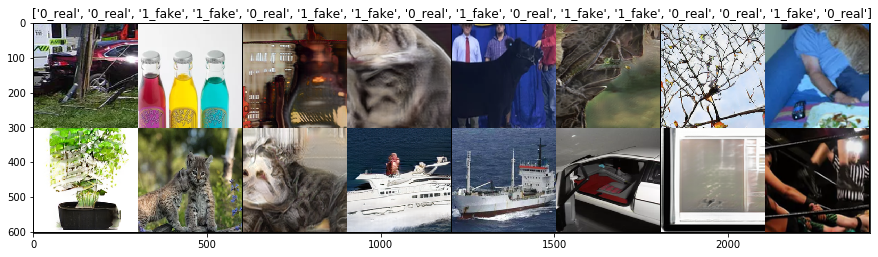

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


plt.figure(figsize=(15,15))
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Xception first blocks implementation: Entry flow block ###

https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568

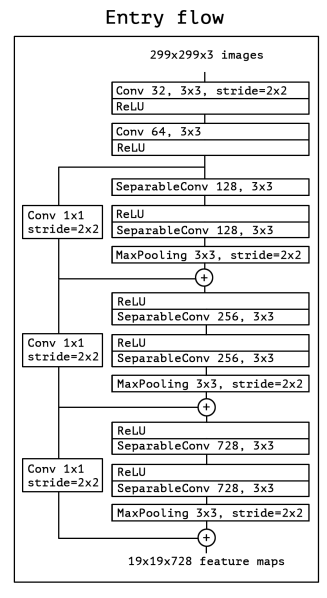

In [17]:
#implementation with reference here
#https://github.com/tstandley/Xception-PyTorch/blob/master/xception.py
class SeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = False):
        super(SeparableConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups = in_channels, bias = bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0, dilation = 1, groups = 1, bias = bias)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pointwise(x) 
        return x
    
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride, repeatTime, relu = True):
        super(Block, self).__init__()
        self.relu = nn.ReLU(inplace = True)

        if in_channels != out_channels or stride != 1:
            self.skipLayer = nn.Conv2d(in_channels, out_channels, 1, stride, bias = False)
            self.skipBatchNorm = nn.BatchNorm2d(out_channels)
        else:
            self.skipLayer = None

        sequential = []
        channels = in_channels

        sequential.append(self.relu)
        sequential.append(SeparableConv(in_channels, out_channels, 3, stride = 1, padding = 1, bias = False))
        sequential.append(nn.BatchNorm2d(out_channels))
        channels = out_channels

        for timeLeft in range(0, repeatTime - 1):
            sequential.append(self.relu)
            sequential.append(SeparableConv(channels, channels, 3, stride = 1, padding = 1, bias = False))
            sequential.append(nn.BatchNorm2d(channels))

        if relu == False:
            sequential = sequential[1:]
        else:
            sequential[0] = nn.ReLU(inplace = True)

        if stride != 1:
            sequential.append(nn.MaxPool2d(3, stride, 1))

        self.sequential = nn.Sequential(*sequential)
    def forward(self, x):
        main = self.sequential(x)
        if self.skipLayer is not None:
            skipLayer = self.skipLayer(x)
            skipLayer = self.skipBatchNorm(skipLayer)
        else:
            skipLayer = x
        
        main += skipLayer
        return main

In [18]:
class Xception_entry_flow(nn.Module):
    def __init__(self):
        super(Xception_entry_flow, self).__init__()
        ####################  
        self.conv1_1 = nn.Conv2d(3, 32, 3, 2, padding = 0, bias = False)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace = True)
        
        self.conv1_2 = nn.Conv2d(32, 64, 3, padding = 0, bias = False)
        self.bn1_2 = nn.BatchNorm2d(64)
        #ReLU here
        #####################
        self.block1 = Block(64, 128, 2, 2, relu = False)
        #######################
        self.block2 = Block(128, 256, 2, 2, relu = True)
        ########################
        self.block3 = Block(256, 728, 2, 2, relu = True)
        #########################
        self.fc1 = nn.Linear(19*19*728, 2)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        #print('input shape', x.shape)
        x = self.conv1_1(x)
        x = self.bn1_1(x)
        x = self.relu(x)
        x = self.conv1_2(x)
        x = self.bn1_2(x)
        x = self.relu(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.relu(x)
        x = x.view(-1, 19*19*728)
        x = self.fc1(x)
        return x


In [19]:
model = Xception_entry_flow()
model = model.to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
num_epochs = 5
since = time.time()
print_every_n_batches = 3000
losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    #running_corrects = 0
    
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % print_every_n_batches == print_every_n_batches - 1:
             #Calculate validation loss
            n = 0
            acc = torch.tensor(0).to(device)
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                y_pred = torch.argmax(model(inputs), 1) 
                acc = torch.add(acc, torch.sum(y_pred == labels))
                n += len(labels)

            val_acc = acc / float(n)
            print('[%d, %5d] training loss: %.3f val acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every_n_batches, val_acc), end = " ")
            val_accs.append(val_acc)
            losses.append(running_loss / print_every_n_batches)
            running_loss = 0.0
            
    
            time_elapsed = time.time() - since
            print(f'Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    torch.save(model, "./patchForensic_nzotalis/model" + str(epoch) + ".pt")
        
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Epoch 1/5
----------
[1,  3000] training loss: 1.715 val acc: 0.501 Time elapsed: 10m 50s
[1,  6000] training loss: 0.734 val acc: 0.501 Time elapsed: 20m 54s
[1,  9000] training loss: 0.705 val acc: 0.505 Time elapsed: 30m 48s
[1, 12000] training loss: 0.714 val acc: 0.498 Time elapsed: 40m 42s
[1, 15000] training loss: 0.695 val acc: 0.502 Time elapsed: 50m 59s
[1, 18000] training loss: 0.694 val acc: 0.500 Time elapsed: 60m 52s
[1, 21000] training loss: 0.738 val acc: 0.504 Time elapsed: 70m 59s
[1, 24000] training loss: 0.693 val acc: 0.503 Time elapsed: 81m 1s
[1, 27000] training loss: 0.694 val acc: 0.508 Time elapsed: 91m 3s
[1, 30000] training loss: 0.693 val acc: 0.506 Time elapsed: 101m 33s
[1, 33000] training loss: 0.695 val acc: 0.513 Time elapsed: 112m 0s
[1, 36000] training loss: 0.694 val acc: 0.516 Time elapsed: 122m 11s
Epoch 2/5
----------
[2,  3000] training loss: 0.692 val acc: 0.522 Time elapsed: 132m 11s
[2,  6000] training loss: 0.691 val acc: 0.521 Time elapsed:

KeyboardInterrupt: 

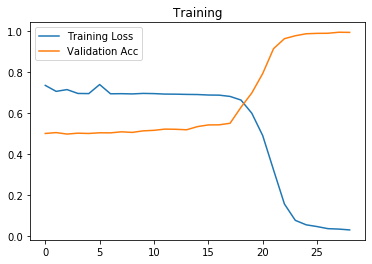

In [21]:
torch.save(model, "./patchForensic_nzotalis/final_save.pt")
plt.title("Training")
plt.plot(losses[1:], label="Training Loss")
plt.plot(val_accs[1:], label="Validation Acc")
plt.legend()

In [22]:
n = 0
acc = torch.tensor(0).to(device)
for data in test_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    y_pred = torch.argmax(model.forward(inputs), 1) 
    acc = torch.add(acc, torch.sum(y_pred == labels))
    n += len(labels)
    
acc / float(n)

tensor(0.9906, device='cuda:0')

In [23]:
gans = os.listdir("./CNN_synth_testset")
test_accs = []
gans.remove("progan")
for gan in tqdm(gans):
    subdirs = os.listdir("./CNN_synth_testset/" + gan)
    if len(subdirs) == 2:
        gan_dataset = datasets.ImageFolder("./CNN_synth_testset/" + gan, transform=test_transform)
    else:
        gan_datasets = [datasets.ImageFolder("./CNN_synth_testset/" + gan + "/" + cat, transform=test_transform) for cat in subdirs]
        gan_dataset = torch.utils.data.ConcatDataset(gan_datasets)
        
    gan_loader = torch.utils.data.DataLoader(gan_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        
    n = 0
    acc = torch.tensor(0).to(device)
    for data in gan_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = torch.argmax(model.forward(inputs), 1) 
        acc = torch.add(acc, torch.sum(y_pred == labels))
        n += len(labels)
    
    test_accs.append(acc / float(n))

100%|██████████| 12/12 [07:05<00:00, 35.49s/it]


<BarContainer object of 12 artists>

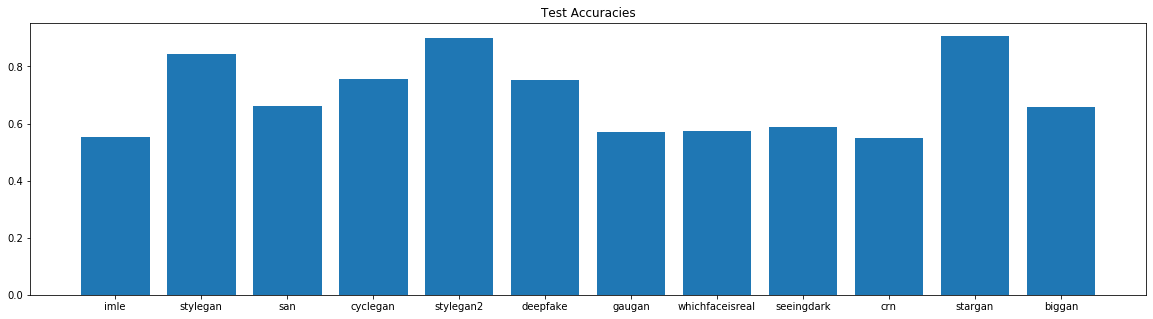

In [24]:
plt.figure(figsize=(20,5))
plt.title("Test Accuracies")
plt.bar(gans, test_accs)

In [25]:
import pickle
with open("./patchForensic_nzotalis/test_accs.txt", "wb") as file:
    pickle.dump(test_accs, file)

In [3]:
import pickle
with open("./patchForensic_nzotalis/test_accs.txt", "rb") as file:
    test_accs = pickle.load(file)
test_accs

[tensor(0.5543, device='cuda:0'),
 tensor(0.8433, device='cuda:0'),
 tensor(0.6621, device='cuda:0'),
 tensor(0.7555, device='cuda:0'),
 tensor(0.8979, device='cuda:0'),
 tensor(0.7510, device='cuda:0'),
 tensor(0.5709, device='cuda:0'),
 tensor(0.5730, device='cuda:0'),
 tensor(0.5889, device='cuda:0'),
 tensor(0.5502, device='cuda:0'),
 tensor(0.9067, device='cuda:0'),
 tensor(0.6578, device='cuda:0')]